## Beam Block
Creating beamblock functions that use wradlib to retrieve PBB and CBB. beamblock flags are then created and the PBB, CBB and flags are converted into fields in an empty radar object.

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image, display
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import gdal
import osr
import numpy as np
import netCDF4
import re
import pyart
import wradlib as wrl
import matplotlib
from matplotlib import cm
from IPython.display import Image, display
from mpl_toolkits.basemap import Basemap
get_ipython().magic(
    'install_ext https://raw.github.com/cpcloud/ipython-\
autotime/master/autotime.py')
get_ipython().magic('load_ext autotime')
get_ipython().magic(
    'install_ext https://raw.github.com/cpcloud/ipython-\
autotime/master/autotime.py')
get_ipython().magic('load_ext autotime')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR:root:Line magic function `%install_ext` not found.
ERROR:root:Line magic function `%install_ext` not found.


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [2]:
"""
pyart.retrieve.beam_block_calc
=======================================

Calculates partial beam block(PBB) and cumulative beam block(CBB)
by using wradlib's beamblock and geotiff functions. PBB and CBB
are then used to created flags when a certain beam block fraction
is passed. Empty radar object is created using Py-ART and then
is filled with beam block data.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    beam_block
    empty_radar_beam_block
    beam_block_flag
    _arrays_to_dict
    _flags_to_dict

"""

import pyart
import numpy as np
import wradlib as wrl


def beam_block(radar, tif_name,
               beam_width=1.0):
    """
    Beam Block Calculation

    Parameters
    ----------
    radar : Radar
        Radar object used.
    tif_name : string
        Name of geotiff file to use for the
        calculation

    Other Parameters
    ----------------
    beam_width : float
        Radar's beam width for calculation.
        Default value is 1.0.

    Returns
    -------
    pbb : array
        Array of partial beam block fractions for each
        gate in each ray.
    cbb: array
        Array of cumulative beam block fractions for
        each gate in each ray.

    References
    ----------
    Bech, J., B. Codina, J. Lorente, and D. Bebbington,
    2003: The sensitivity of single polarization weather
    radar beam blockage correction to variability in the
    vertical refractivity gradient. J. Atmos. Oceanic
    Technol., 20, 845–855

    Heistermann, M., Jacobi, S., and Pfaff, T., 2013:
    Technical Note: An open source library for processing
    weather radar data (wradlib), Hydrol. Earth Syst.
    Sci., 17, 863-871, doi:10.5194/hess-17-863-2013
    
    Helmus, J.J. & Collis, S.M., (2016). The Python ARM
    Radar Toolkit (Py-ART), a Library for Working with
    Weather Radar Data in the Python Programming Language.
    Journal of Open Research Software. 4(1), p.e25.
    DOI: http://doi.org/10.5334/jors.119

    """

    radar.fields.clear()
    _range = radar.range['data']
    #beam_width = np.float(radar.instrument_parameters[
        #'radar_beam_width_v']['data'])
    beamradius = wrl.util.half_power_radius(_range, beam_width)

    rasterfile = tif_name
    data_raster = wrl.io.open_raster(rasterfile)
    proj_raster = wrl.georef.wkt_to_osr(data_raster.GetProjection())
    rastercoords, rastervalues = wrl.io.read_raster_data(rasterfile)
    sitecoords = (np.float(radar.longitude['data']),
                  np.float(radar.latitude['data']),
                  np.float(radar.altitude['data']))

    nrays = radar.nrays
    nbins = radar.ngates
    elev = radar.elevation['data']
    azimuths = radar.azimuth['data']

    rg, azg = np.meshgrid(_range, azimuths)
    rg, eleg = np.meshgrid(_range, elev)
    lon, lat, alt = wrl.georef.polar2lonlatalt_n(rg, azg,
                                                 eleg, sitecoords)
    #lon = radar.gate_longitude['data']
    #lat = radar.gate_latitude['data']
    #alt = radar.gate_altitude['data']
    x_pol, y_pol,  = wrl.georef.reproject(
        lon, lat, projection_target=proj_raster)
    polcoords = np.dstack((x_pol, y_pol))

    rlimits = (x_pol.min(), y_pol.min(),
               x_pol.max(), y_pol.max())
    # Clip the region inside our bounding box
    ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
    rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
    rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

    # Map rastervalues to polar grid points
    polarvalues = wrl.ipol.cart2irregular_spline(
        rastercoords, rastervalues, polcoords)
    #bh = wrl.qual.beam_height_ft_doviak(
       # _range, elev, degrees=True, re=6371000)

    pbb = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
    pbb = np.ma.masked_invalid(pbb)
    maxindex = np.nanargmax(pbb, axis=1)
    cbb = np.copy(pbb)
    # Iterate over all beams
    for ii, index in enumerate(maxindex):
        premax = 0.
        for jj in range(index):
            # Only iterate to max index to make this faster
            if pbb[ii, jj] > premax:
                cbb[ii, jj] = pbb[ii, jj]
                premax = cbb[ii, jj]
            else:
                cbb[ii, jj] = premax
        # beyond max index, everything is max anyway
        cbb[ii, index:] = pbb[ii, index]
    
    return pbb, cbb

def beam_block_flag(pbb_all, cbb_all, pbb_threshold,
                    cbb_threshold):
    """ Takes PBB and CBB arrays created from the
    beam_block function and user chosen thresholds
    to create and array of 1s and 0s, 1 is a flagged gate
    where the fraction value is past the threshold. """
    pbb_flags = np.empty_like(pbb_all)
    pbb_flags[pbb_all > pbb_threshold] = True
    pbb_flags[pbb_all < pbb_threshold] = False

    cbb_flags = np.empty_like(cbb_all)
    cbb_flags[cbb_all > cbb_threshold] = True
    cbb_flags[cbb_all < cbb_threshold] = False
    return pbb_flags, cbb_flags

def empty_radar_beam_block_rhi(ngates, rays_per_sweep, nsweeps,
                               lon, lat, alt, range_start,
                               gate_space, azimuth, elev_start,
                               elev_end):
    """ Creates a radar object with no fields based on
    user inputed dimensions. The empty radar is to then
    be used to add PBB, CBB and the flags for both. """
    radar = pyart.testing.make_empty_rhi_radar(
        ngates, rays_per_sweep, nsweeps)
    nrays = rays_per_sweep * nsweeps
    radar.longitude['data'] = np.array([lon])
    radar.latitude['data'] = np.array([lat])
    radar.altitude['data'] = np.array([alt])
    # radar.azimuth['data'] = np.linspace(0, 360, rays_per_sweep)
    radar.range['data'] = np.linspace(
        range_start, (ngates - 1)*gate_space + range_start, ngates)
    radar.elevation['data'] = np.linspace(elev_start, elev_end, nrays)
    radar.azimuth['data'] = np.array([azimuth] * nrays)
    radar.fixed_angle['data'] = np.array([azimuth])
    radar.metadata['instrument_name'] = 'beam_block_radar_object'
    return radar

def empty_radar_beam_block_ppi(ngates, rays_per_sweep, nsweeps,
                           lon, lat, alt, range_start,
                           gate_space, elevations):
    """ Creates a radar object with no fields based on
    user inputed dimensions. The empty radar is to then
    be used to add PBB, CBB and the flags for both. """
    radar = pyart.testing.make_empty_ppi_radar(
        ngates, rays_per_sweep, nsweeps)
    radar.longitude['data'] = np.array([lon])
    radar.latitude['data'] = np.array([lat])
    radar.altitude['data'] = np.array([alt])
    radar.azimuth['data'] = np.linspace(0, 360, rays_per_sweep)
    radar.range['data'] = np.linspace(
        range_start, (ngates - 1)*gate_space + range_start, ngates)
    radar.fixed_angle['data'] = elevations
    radar.elevation['data'] = np.array([elevations] * rays_per_sweep)
    radar.metadata['instrument_name'] = 'beam_block_radar_object'
    return radar

def _arrays_to_dict(pbb_all, cbb_all):
    """ Function that takes the PBB and CBB arrays
    and turns them into dictionaries to be used and added
    to the pyart radar object. """
    pbb_dict = {}
    pbb_dict['coordinates'] = 'elevation, azimuth, range'
    pbb_dict['units'] = 'unitless'
    pbb_dict['data'] = pbb_all
    pbb_dict['standard_name'] = 'partial_beam_block'
    pbb_dict['long_name'] = 'Partial Beam Block Fraction'
    pbb_dict['comment'] = 'Partial beam block fraction due to terrain'

    cbb_dict = {}
    cbb_dict['coordinates'] = 'elevation, azimuth, range'
    cbb_dict['units'] = 'unitless'
    cbb_dict['data'] = cbb_all
    cbb_dict['standard_name'] = 'cumulative_beam_block'
    cbb_dict['long_name'] = 'Cumulative Beam Block Fraction'
    cbb_dict['comment'] = 'Cumulative beam block fraction due to terrain'
    return pbb_dict, cbb_dict

def _flags_to_dict(pbb_flags, cbb_flags):
    """ Function that takes the PBB_flag and CBB_flag
    arrays and turns them into dictionaries to be used
    and added to the pyart radar object. """
    pbb_flag_dict = {}
    pbb_flag_dict['units'] = 'unitless'
    pbb_flag_dict['data'] = pbb_flags
    pbb_flag_dict['standard_name'] = 'partial_beam_block_flag'
    pbb_flag_dict['long_name'] = 'Partial Beam Block Flag'
    pbb_flag_dict['comment'] = 'Partial beam block fraction flag, ' \
                            '1 for flagged values, 0 for non-flagged.'

    cbb_flag_dict = {}
    cbb_flag_dict['units'] = 'unitless'
    cbb_flag_dict['data'] = cbb_flags
    cbb_flag_dict['standard_name'] = 'cumulative_beam_block_flag'
    cbb_flag_dict['long_name'] = 'Cumulative Beam Block Flag'
    cbb_flag_dict['comment'] = 'Cumulative beam block fraction flag, ' \
                            '1 for flagged values, 0 for non-flagged.'
    return pbb_flag_dict, cbb_flag_dict

time: 196 ms


In [3]:
azimuths = ([0, 17, 20, 50, 120, 131, 145, 146, 147, 152, 165])
radars = []
for azimuth in azimuths:
    radar = empty_radar_beam_block_rhi(983, 361, 1, -28.0257,
                                       39.0916, 40.0, 0, 100,
                                       azimuth, 0, 90)
    radars += [radar]

time: 10.6 ms


In [4]:
tif_name = '/home/zsherman/beam_block/data/dtm_gra.tif'

time: 1.67 ms


In [5]:
for radar in radars:
    pbb_all, cbb_all = beam_block(
        radar, tif_name, 1.0)
    pbb_dict, cbb_dict = _arrays_to_dict(
        pbb_all, cbb_all)
    radar.add_field('partial_beam_block',
                    pbb_dict, replace_existing=True)
    radar.add_field('cumulative_beam_block',
                    cbb_dict, replace_existing=True)

/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: invalid value encountered in sqrt
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: divide by zero encountered in true_divide
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: invalid value encountered in arcsin
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)


time: 6.98 s


In [6]:
n_block = []
CBB = radars[9].fields['cumulative_beam_block']['data']
for i in range(len(radars[9].range['data'])):
    not_blocked = np.argwhere(CBB[:, i] < 0.01)
    n_block.append(not_blocked.min())
n_block[30]

9

time: 21.2 ms


In [7]:
foo = (1, 983)
bar = np.ones(foo)

time: 1.06 ms


In [8]:
for i in range(len(radars[9].range['data'])):
    bar[0, i] = radars[9].elevation['data'][n_block[i]]

time: 1.66 ms


In [9]:
bar[0, :]

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.75,
        0.75,  2.25,  2.25,  2.25,  2.25,  2.25,  2.25,  2.25,  2.25,
        2.25,  2.25,  2.25,  2.25,  2.25,  2.25,  2.25,  2.25,  2.25,
        2.25,  2.25,  2.25,  2.25,  2.5 ,  2.5 ,  2.75,  2.75,  3.  ,
        3.25,  3.5 ,  3.75,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,
        5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
        5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
        5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
        5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
        5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
        5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
        5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
        5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
        5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,  5.  ,
        5.  ,  5.  ,

time: 14.5 ms


In [16]:
# mask[:, 0].max() + 1
# radars[1].elevation['data'][mask[:, 0].max() + 1]
# ind = np.argwhere(np.round(radar_ppi.azimuth['data'], decimals=3) ==
#                   np.round(radars[1].azimuth['data'][0], decimals=3))
# radar_ppi.fields['low_el']['data'][ind[0]] = radars[1].elevation['data'][mask[:, 0].max() + 1]

time: 2.87 ms


In [17]:
radar_ppi = empty_radar_beam_block_ppi(983, 500, 1, -28.0257,
                                       39.0916, 40.0, 0, 100,
                                       elevations=0.0)

time: 3.35 ms


In [18]:
low_el_ray = {}
low_el_list = []

azimuths = np.arange(0, 360)
for azimuth in azimuths:
    radar = empty_radar_beam_block_rhi(1600, 361, 1, -28.0257,
                                       39.0916, 40.0, 0, 10,
                                       azimuth, 0, 90)

    pbb_all, cbb_all = beam_block(
        radar, tif_name, 1.0)
    CBB = cbb_all
    blocked = np.argwhere(CBB > 0.01)[:, :]
    shape = (1, radar.ngates)
    one_az = np.ones(shape)
    one_az[:] = radar.elevation['data'][blocked[:, 0].max() + 1]
    low_el_list.append(one_az)
    del radar

low_el_ray['data'] = np.concatenate(low_el_list)
radar_ppi_ray = empty_radar_beam_block_ppi(1600, len(azimuths), 1, -28.0257,
                                           39.0916, 40.0, 0, 10,
                                           elevations=0.0)
radar_ppi_ray.azimuth['data'] = azimuths
radar_ppi_ray.add_field('low_el_ray',
                        low_el_ray, replace_existing=True)

/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: invalid value encountered in sqrt
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: divide by zero encountered in true_divide
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: invalid value encountered in arcsin
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)


time: 5min 50s


In [19]:
low_el_list = []
azimuths = np.arange(0, 360)
for azimuth in azimuths:
    radar = empty_radar_beam_block_rhi(1400, 361, 1, -28.0257,
                                       39.0916, 40.0, 0, 10,
                                       azimuth, 0, 90)
    pbb, cbb = beam_block(
        radar, tif_name, 1.0)
    not_blocked_lowest = []
    shape = (1, radar.ngates)
    one_az = np.ones(shape)
    for i in range(len(radar.range['data'])):
        not_blocked = np.argwhere(cbb[:, i] < 0.01)
        not_blocked_lowest.append(not_blocked.min())
        one_az[0, i] = radar.elevation['data'][not_blocked_lowest[i]]
    low_el_list.append(one_az)
    del radar

low_el_not_blocked = {}
low_el_not_blocked_all = np.concatenate(low_el_list)
low_el_not_blocked['units'] = 'unitless'
low_el_not_blocked['data'] = low_el_not_blocked_all
low_el_not_blocked['standard_name'] = 'low_el_not_blocked'
low_el_not_blocked['long_name'] = 'Lowest Elevation Not Blocked'
low_el_not_blocked['comment'] = 'Lowest elevation for when ' \
                        'each gate will achieve less than 0.01 CBB.'

radar_ppi = empty_radar_beam_block_ppi(1400, len(azimuths), 1, -28.0257,
                                       39.0916, 40.0, 0, 10,
                                       elevations=0.0)
radar_ppi.azimuth['data'] = azimuths
radar_ppi.add_field(
    'low_el_not_blocked', low_el_not_blocked,
    replace_existing=True)

/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: invalid value encountered in sqrt
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: divide by zero encountered in true_divide
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: invalid value encountered in arcsin
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)


time: 5min 12s


In [20]:
def convertXY(xy_source, inproj, outproj):
    # function to convert coordinates

    shape = xy_source[0, :, :].shape
    size = xy_source[0, :, :].size

    # the ct object takes and returns pairs of x,y, not 2d grids
    # so the the grid needs to be reshaped (flattened) and back.
    ct = osr.CoordinateTransformation(inproj, outproj)
    xy_target = np.array(ct.TransformPoints(xy_source.reshape(2, size).T))

    xx = xy_target[:, 0].reshape(shape)
    yy = xy_target[:, 1].reshape(shape)

    return xx, yy

time: 3.61 ms


In [21]:
ds = gdal.Open("/home/zsherman/beam_block/data/dtm_gra.tif")

data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()


xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
ymax = gt[3] - yres * 0.5

ds = None

# create a grid of xy coordinates in the original projection
xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]

time: 55.9 ms


In [22]:
llcrnrlat=39
urcrnrlon=-27.9
llcrnrlon=-28.1
urcrnrlat=39.1
lats = np.arange(llcrnrlat, urcrnrlat, .04)
lons = np.arange(llcrnrlon, urcrnrlon, .04)

fig = plt.figure(figsize=(12, 7))
m = Basemap(projection='lcc', lon_0=-28, lat_0=39, resolution='c', 
            llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)
# Get the target projection from the basemap object
outproj = osr.SpatialReference()
outproj.ImportFromProj4(m.proj4string)

# Convert from source projection to basemap projection
xx, yy = convertXY(xy_source, inproj, outproj)

elev = data.T
the_sea = data.T < 0.1
masked_data = np.ma.masked_where(the_sea, elev)

time: 1.23 s


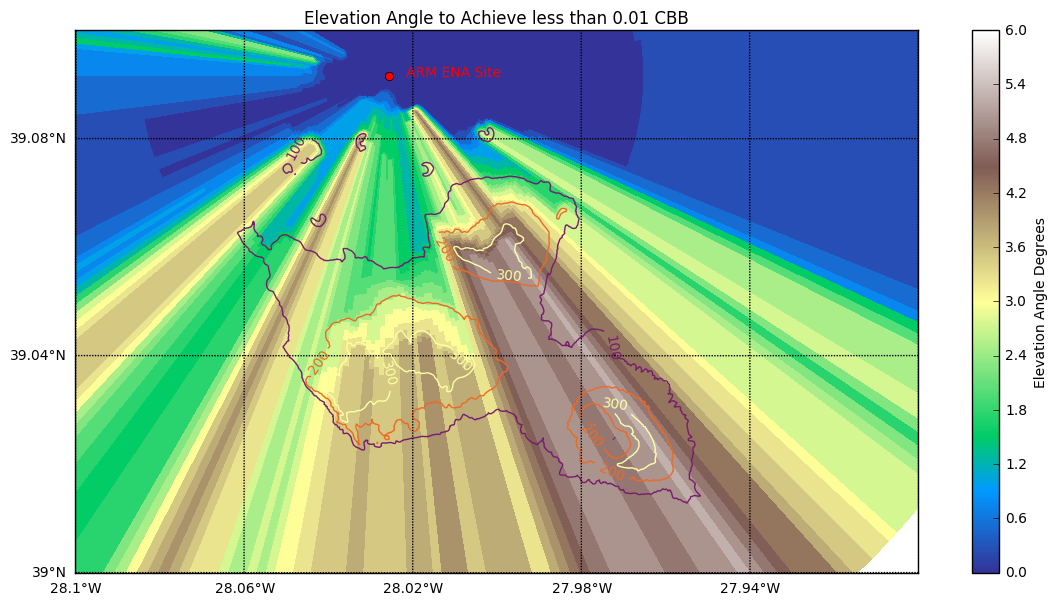

time: 2.01 s


In [23]:
title = 'Elevation Angle to Achieve less than 0.01 CBB'
cb_label = 'Elevation Angle Degrees'
fig = plt.figure(figsize=(14, 7))
display = pyart.graph.RadarMapDisplay(radar_ppi)
display.plot_ppi_map('low_el_not_blocked', basemap=m,
                       lat_lines=lats, lon_lines=lons,
                       vmin=0, vmax=6, cmap=plt.cm.terrain,
                       title=title, colorbar_label=cb_label)
#-28.0257, 39.0916
display.plot_point(-28.0257, 39.0916,
                    symbol='ro')
plt.annotate('ARM ENA Site', m(-28.0217, 39.0916), color='r')
CS = m.contour(xx, yy, masked_data,
               levels=np.arange(0, 400, 100),
               linewidths=1, cmap=plt.cm.inferno)

plt.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')

plt.savefig(
    '/home/zsherman/beam_block/images/elevation_angle_for_0.01_cbb_10m_gatespace.png',
    bbox_inches='tight')
plt.show()

In [24]:
print(m(-28.0257, 39.0916))

(6423.481764717057, 10181.022104284883)
time: 967 µs


In [25]:
radar_ppi_ray.fields['low_el_ray']['data'][:, 0:1200] = 6

time: 3.41 ms


In [37]:
llcrnrlat=38.92
urcrnrlon=-27.78
llcrnrlon=-28.26
urcrnrlat=39.28
lats = np.arange(llcrnrlat, urcrnrlat, .04)
lons = np.arange(llcrnrlon, urcrnrlon, .08)

fig = plt.figure(figsize=(12, 7))
m = Basemap(projection='lcc', lon_0=-28, lat_0=39, resolution='c', 
            llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)
# Get the target projection from the basemap object
outproj = osr.SpatialReference()
outproj.ImportFromProj4(m.proj4string)

# Convert from source projection to basemap projection
xx, yy = convertXY(xy_source, inproj, outproj)

elev = data.T
the_sea = data.T < 0.1
masked_data = np.ma.masked_where(the_sea, elev)

time: 1.25 s


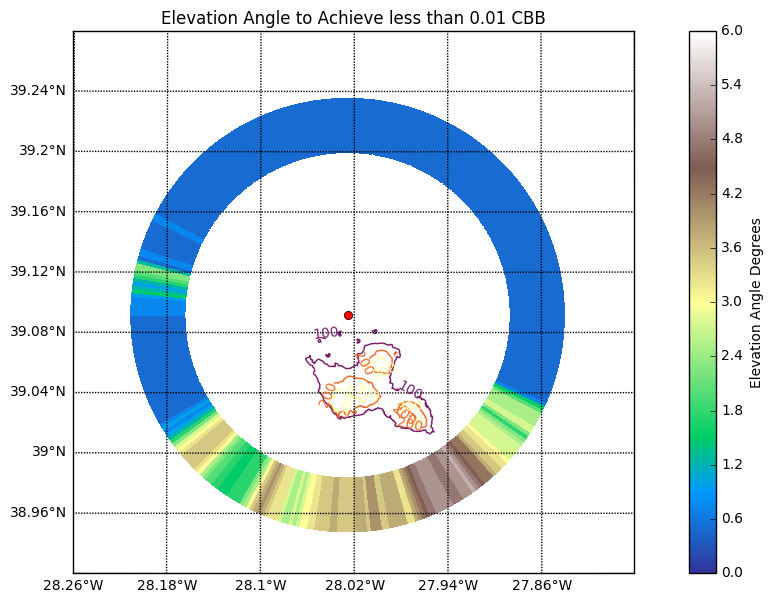

time: 2.15 s


In [38]:
title = 'Elevation Angle to Achieve less than 0.01 CBB'
cb_label = 'Elevation Angle Degrees'
fig = plt.figure(figsize=(14, 7))
display2 = pyart.graph.RadarMapDisplay(radar_ppi_ray)
display2.plot_ppi_map('low_el_ray', basemap=m,
                       lat_lines=lats, lon_lines=lons,
                       vmin=0, vmax=6, cmap=plt.cm.terrain,
                       title=title, colorbar_label=cb_label)
#-28.0257, 39.0916
display2.plot_point(-28.0257, 39.0916,
                    symbol='ro')
#plt.annotate('ARM ENA Site', (18114.71813849059, 19058.365225780377), color='r')
CS = m.contour(xx, yy, masked_data,
               levels=np.arange(0, 400, 100),
               linewidths=1, cmap=plt.cm.inferno)

plt.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')

plt.savefig(
    '/home/zsherman/beam_block/images/elevation_angle_for_0.01_cbb_ray.png',
    bbox_inches='tight')
plt.show()